## Import Libraries

Import all necessary libraries for clustering analysis.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Clustering Libraries
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score

# Visualization Libraries 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully")
print("Prepared for clustering analysis")

Libraries imported successfully
Prepared for clustering analysis


## Data Loading and Preparation

Load the football dataset and prepare it for clustering analysis.

In [2]:
# Load the Football Dataset
print("Loading Football Player Data...")
print("="*50)

# Load data
df = pd.read_csv('../data/data_football_ratings.csv')

print("Dataset Basic Information:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

print(f"\n First 5 rows:")
display(df.head())

print(f"\n Dataset Info:")
print(df.info())

print(f"\n🔢 Missing Values:")
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
 print(missing_values[missing_values > 0])
else:
 print(" No missing values found!")

print(f"\n Numerical Columns Statistics:")
print(df.describe())

Loading Football Player Data...
Dataset Basic Information:
Shape: (50652, 63)
Columns: ['competition', 'date', 'match', 'team', 'pos', 'pos_role', 'player', 'rater', 'is_human', 'original_rating', 'goals', 'assists', 'shots_ontarget', 'shots_offtarget', 'shotsblocked', 'chances2score', 'drib_success', 'drib_unsuccess', 'keypasses', 'touches', 'passes_acc', 'passes_inacc', 'crosses_acc', 'crosses_inacc', 'lballs_acc', 'lballs_inacc', 'grduels_w', 'grduels_l', 'aerials_w', 'aerials_l', 'poss_lost', 'fouls', 'wasfouled', 'clearances', 'stop_shots', 'interceptions', 'tackles', 'dribbled_past', 'tballs_acc', 'tballs_inacc', 'ycards', 'rcards', 'dangmistakes', 'countattack', 'offsides', 'goals_ag_otb', 'goals_ag_itb', 'saves_itb', 'saves_otb', 'saved_pen', 'missed_penalties', 'owngoals', 'degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'flow_centrality', 'flow_success', 'betweenness2goals', 'win', 'lost', 'is_home_team', 'minutesPlayed', 'game_duration']

 First 5 rows:

,competition,date,match,team,pos,pos_role,player,rater,is_human,original_rating,...,betweenness_centrality,closeness_centrality,flow_centrality,flow_success,betweenness2goals,win,lost,is_home_team,minutesPlayed,game_duration
0,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,Kicker,1,3.50,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90,90
1,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,WhoScored,0,6.56,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90,90
2,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,SofaScore,0,6.70,...,0.143055,0.603571,0.304348,0.000000,0.0,0,1,0,90,90
3,Euro 2016,10/06/2016,"France - Romania, 2 - 1",France,Sub,Sub,Anthony Martial,WhoScored,0,6.19,...,0.051556,0.524845,0.041096,0.166667,0.0,1,0,1,13,90
4,Euro 2016,10/06/2016,"France - Romania, 2 - 1",Romania,MF,DMC,Mihai Pintilii,Kicker,1,3.50,...,0.333284,0.710084,0.347826,0.675075,0.0,0,1,0,90,90



 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50652 entries, 0 to 50651
Data columns (total 63 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   competition             50652 non-null  object 
 1   date                    50652 non-null  object 
 2   match                   50652 non-null  object 
 3   team                    50652 non-null  object 
 4   pos                     50652 non-null  object 
 5   pos_role                50652 non-null  object 
 6   player                  50652 non-null  object 
 7   rater                   50652 non-null  object 
 8   is_human                50652 non-null  int64  
 9   original_rating         50652 non-null  float64
 10  goals                   50652 non-null  int64  
 11  assists                 50652 non-null  int64  
 12  shots_ontarget          50652 non-null  int64  
 13  shots_offtarget         50652 non-null  int64  
 14  shotsblocked          

In [3]:
# Feature Selection for Clustering
print("Selecting Features for Player Clustering")
print("="*60)

print("Analyzing available features...")

# Exclude non-meaningful features for clustering
exclude_features = [
 'player', # Player name (identifier)
 'team', # Team (contextual, but we'll analyze separately)
 'competition', # Competition (contextual)
 'date', # Date (temporal)
 'match', # Match identifier
 'rater', # Rating source
 'is_human', # Not relevant for player style
 'original_rating' # Subjective rating, we want to find patterns in objective stats
]

# Select performance-based features for clustering
performance_features = [
 # Offensive Performance
 'goals', 'assists', 'shots_ontarget', 'shots_offtarget', 'chances2score',
 
 # Passing Performance 
 'keypasses', 'passes_acc', 'passes_inacc', 'crosses_acc', 'crosses_inacc',
 'lballs_acc', 'lballs_inacc', 'tballs_acc', 'tballs_inacc',
 
 # Dribbling & Ball Control
 'drib_success', 'drib_unsuccess', 'touches', 'poss_lost',
 
 # Defensive Performance
 'tackles', 'interceptions', 'clearances', 'stop_shots', 'dribbled_past',
 
 # Physical Performance
 'aerials_w', 'aerials_l', 'grduels_w', 'grduels_l',
 
 # Disciplinary
 'fouls', 'wasfouled', 'ycards', 'rcards', 'dangmistakes',
 
 # Goalkeeping (for GK)
 'saves_itb', 'saves_otb', 'saved_pen', 'goals_ag_itb', 'goals_ag_otb',
 
 # Additional metrics
 'shotsblocked', 'countattack', 'offsides', 'missed_penalties', 'owngoals',
 'minutesPlayed', 'game_duration'
]

# Check which features are available
available_features = [f for f in performance_features if f in df.columns]
print("Available performance features ({}):".format(len(available_features)))
for i, feature in enumerate(available_features, 1):
    print("  {:2d}. {}".format(i, feature))

# Create clustering dataset
clustering_data = df[available_features].copy()

print(f"\n Clustering Dataset Shape: {clustering_data.shape}")
print(f" Feature Coverage: {len(available_features)}/{len(performance_features)} features available")

# Remove rows with missing values
initial_rows = len(clustering_data)
clustering_data = clustering_data.dropna()
final_rows = len(clustering_data)

print(f"\n🧹 Data Cleaning:")
print(f" Initial rows: {initial_rows}")
print(f" Final rows: {final_rows}")
print(f" Removed: {initial_rows - final_rows} rows with missing values")

# Get additional contextual information
player_info = df[['player', 'pos', 'pos_role', 'team', 'competition']].copy()
player_info = player_info.iloc[:final_rows] # Match the cleaned data

print(f"\n Dataset ready for clustering analysis")

Selecting Features for Player Clustering
Analyzing available features...
Available performance features (44):
   1. goals
   2. assists
   3. shots_ontarget
   4. shots_offtarget
   5. chances2score
   6. keypasses
   7. passes_acc
   8. passes_inacc
   9. crosses_acc
  10. crosses_inacc
  11. lballs_acc
  12. lballs_inacc
  13. tballs_acc
  14. tballs_inacc
  15. drib_success
  16. drib_unsuccess
  17. touches
  18. poss_lost
  19. tackles
  20. interceptions
  21. clearances
  22. stop_shots
  23. dribbled_past
  24. aerials_w
  25. aerials_l
  26. grduels_w
  27. grduels_l
  28. fouls
  29. wasfouled
  30. ycards
  31. rcards
  32. dangmistakes
  33. saves_itb
  34. saves_otb
  35. saved_pen
  36. goals_ag_itb
  37. goals_ag_otb
  38. shotsblocked
  39. countattack
  40. offsides
  41. missed_penalties
  42. owngoals
  43. minutesPlayed
  44. game_duration

 Clustering Dataset Shape: (50652, 44)
 Feature Coverage: 44/44 features available

🧹 Data Cleaning:
 Initial rows: 50652
 Fina

## Data Preprocessing

Prepare the data for clustering by handling scaling and normalization.

In [4]:
# Data Preprocessing for Clustering
print(" Data Preprocessing for Clustering")
print("="*50)

# 1. Handle outliers using IQR method
def remove_outliers_iqr(data, threshold=1.5):
 """Remove outliers using IQR method"""
 Q1 = data.quantile(0.25)
 Q3 = data.quantile(0.75)
 IQR = Q3 - Q1
 lower_bound = Q1 - threshold * IQR
 upper_bound = Q3 + threshold * IQR
 
 # Create mask for non-outliers
 mask = ~((data < lower_bound) | (data > upper_bound)).any(axis=1)
 return data[mask], mask

print(" Removing outliers...")
initial_size = len(clustering_data)
clustering_data_clean, outlier_mask = remove_outliers_iqr(clustering_data)
player_info_clean = player_info[outlier_mask]

print(f" Initial samples: {initial_size}")
print(f" After outlier removal: {len(clustering_data_clean)}")
print(f" Outliers removed: {initial_size - len(clustering_data_clean)}")

# 2. Feature Scaling
print(f"\n Applying Feature Scaling...")

# StandardScaler (mean=0, std=1) - good for most clustering algorithms
scaler_standard = StandardScaler()
data_standard = scaler_standard.fit_transform(clustering_data_clean)
data_standard = pd.DataFrame(data_standard, columns=clustering_data_clean.columns)

# MinMaxScaler (0-1 range) - good for algorithms sensitive to feature ranges
scaler_minmax = MinMaxScaler()
data_minmax = scaler_minmax.fit_transform(clustering_data_clean)
data_minmax = pd.DataFrame(data_minmax, columns=clustering_data_clean.columns)

print(" Created two scaled versions:")
print(" StandardScaler: Mean=0, Std=1")
print(" MinMaxScaler: Range=[0,1]")

# 3. Dimensionality Reduction (Optional)
print(f"\n Applying PCA for Dimensionality Analysis...")

pca = PCA()
pca_result = pca.fit_transform(data_standard)

# Calculate cumulative variance explained
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1
n_components_90 = np.argmax(cumsum_variance >= 0.90) + 1

print(f" PCA Analysis:")
print(f" Original features: {data_standard.shape[1]}")
print(f" Components for 90% variance: {n_components_90}")
print(f" Components for 95% variance: {n_components_95}")

# Create reduced datasets
pca_90 = PCA(n_components=n_components_90)
data_pca_90 = pca_90.fit_transform(data_standard)

pca_95 = PCA(n_components=n_components_95)
data_pca_95 = pca_95.fit_transform(data_standard)

print(f"\n Preprocessing Complete!")
print(f" Available datasets for clustering:")
print(f" • Original (cleaned): {clustering_data_clean.shape}")
print(f" • StandardScaled: {data_standard.shape}")
print(f" • MinMaxScaled: {data_minmax.shape}")
print(f" • PCA 90%: {data_pca_90.shape}")
print(f" • PCA 95%: {data_pca_95.shape}")

 Data Preprocessing for Clustering
 Removing outliers...
 Initial samples: 50652
 After outlier removal: 4188
 Outliers removed: 46464

 Applying Feature Scaling...
 Created two scaled versions:
 StandardScaler: Mean=0, Std=1
 MinMaxScaler: Range=[0,1]

 Applying PCA for Dimensionality Analysis...
 PCA Analysis:
 Original features: 44
 Components for 90% variance: 16
 Components for 95% variance: 18

 Preprocessing Complete!
 Available datasets for clustering:
 • Original (cleaned): (4188, 44)
 • StandardScaled: (4188, 44)
 • MinMaxScaled: (4188, 44)
 • PCA 90%: (4188, 16)
 • PCA 95%: (4188, 18)


## Exploratory Data Analysis

visualize the data to understand patterns before clustering.

 Exploratory Data Analysis


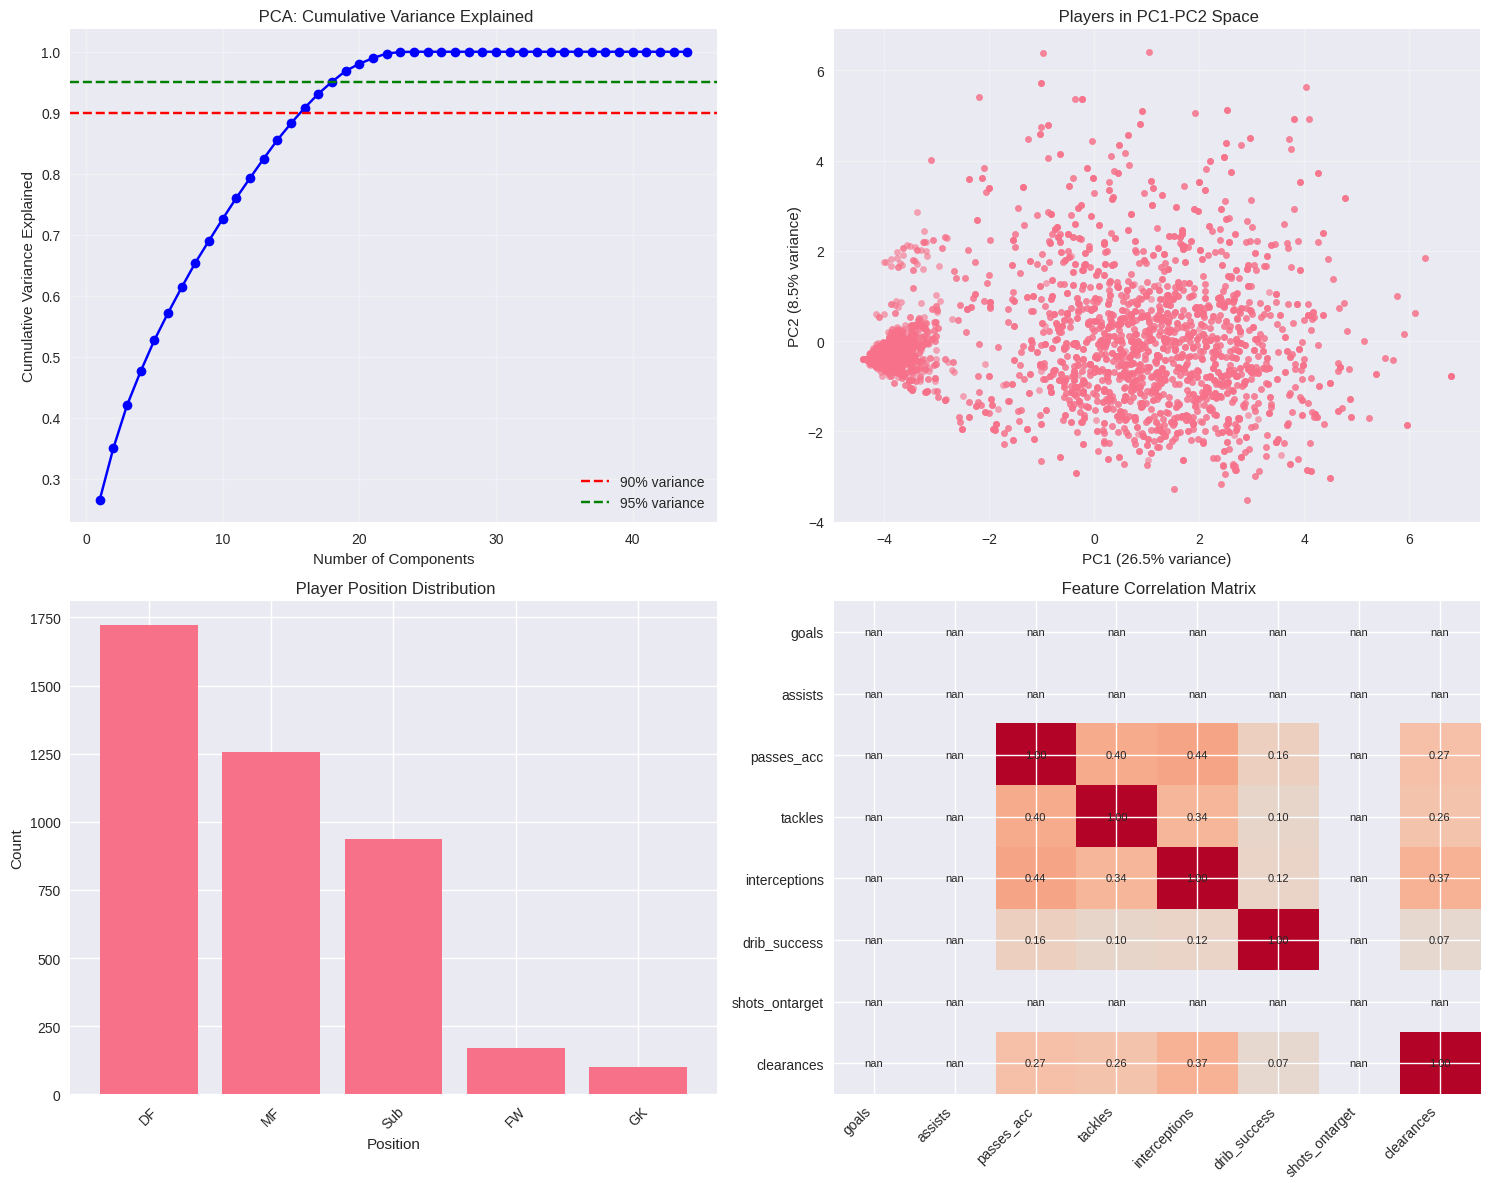


 Statistical Summary by Position:
  Position  Count  Avg_Goals  Avg_Passes  Avg_Tackles  Avg_Dribbles
0       DF   1724        0.0       35.22         1.44          0.25
1      Sub    937        0.0        2.44         0.11          0.04
2       MF   1258        0.0       31.17         1.39          0.32
3       GK    100        0.0       14.85         0.02          0.00
4       FW    169        0.0       13.02         0.57          0.33

 EDA Complete - Prepared for clustering!


In [5]:
# Exploratory Data Analysis
print(" Exploratory Data Analysis")
print("="*50)

# 1. PCA Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Variance explained plot
axes[0, 0].plot(range(1, len(cumsum_variance) + 1), cumsum_variance, 'bo-')
axes[0, 0].axhline(y=0.90, color='r', linestyle='--', label='90% variance')
axes[0, 0].axhline(y=0.95, color='g', linestyle='--', label='95% variance')
axes[0, 0].set_xlabel('Number of Components')
axes[0, 0].set_ylabel('Cumulative Variance Explained')
axes[0, 0].set_title(' PCA: Cumulative Variance Explained')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# First two principal components
pca_2d = PCA(n_components=2)
data_2d = pca_2d.fit_transform(data_standard)

axes[0, 1].scatter(data_2d[:, 0], data_2d[:, 1], alpha=0.6, s=20)
axes[0, 1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)')
axes[0, 1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)')
axes[0, 1].set_title(' Players in PC1-PC2 Space')
axes[0, 1].grid(True, alpha=0.3)

# Position distribution
position_counts = player_info_clean['pos'].value_counts()
axes[1, 0].bar(position_counts.index, position_counts.values)
axes[1, 0].set_xlabel('Position')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title(' Player Position Distribution')
axes[1, 0].tick_params(axis='x', rotation=45)

# Feature correlation heatmap (top features)
top_features = ['goals', 'assists', 'passes_acc', 'tackles', 'interceptions', 
 'drib_success', 'shots_ontarget', 'clearances']
available_top_features = [f for f in top_features if f in clustering_data_clean.columns]

if len(available_top_features) > 0:
 corr_matrix = clustering_data_clean[available_top_features].corr()
 im = axes[1, 1].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
 axes[1, 1].set_xticks(range(len(available_top_features)))
 axes[1, 1].set_yticks(range(len(available_top_features)))
 axes[1, 1].set_xticklabels(available_top_features, rotation=45, ha='right')
 axes[1, 1].set_yticklabels(available_top_features)
 axes[1, 1].set_title(' Feature Correlation Matrix')
 
 # Add correlation values
 for i in range(len(available_top_features)):
  for j in range(len(available_top_features)):
   axes[1, 1].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
    ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# 2. Statistical Summary by Position
print(f"\n Statistical Summary by Position:")
position_stats = []

for pos in player_info_clean['pos'].unique():
 pos_mask = player_info_clean['pos'] == pos
 pos_data = clustering_data_clean[pos_mask]
 
 if len(pos_data) > 5: # Only analyze positions with enough samples
  stats = {
   'Position': pos,
   'Count': len(pos_data),
   'Avg_Goals': pos_data['goals'].mean() if 'goals' in pos_data.columns else 0,
   'Avg_Passes': pos_data['passes_acc'].mean() if 'passes_acc' in pos_data.columns else 0,
   'Avg_Tackles': pos_data['tackles'].mean() if 'tackles' in pos_data.columns else 0,
   'Avg_Dribbles': pos_data['drib_success'].mean() if 'drib_success' in pos_data.columns else 0
  }
  position_stats.append(stats)

if position_stats:
 position_df = pd.DataFrame(position_stats)
 print(position_df.round(2))

print(f"\n EDA Complete - Prepared for clustering!")

## Finding Optimal Number of Clusters

use multiple methods to determine the best number of clusters.

 Finding Optimal Number of Clusters
 Testing different cluster numbers...
 Testing k=2... Silhouette: 0.185
 Testing k=3... Silhouette: 0.190
 Testing k=4... Silhouette: 0.166
 Testing k=5... Silhouette: 0.173
 Testing k=6... Silhouette: 0.180
 Testing k=7... Silhouette: 0.169
 Testing k=8... Silhouette: 0.170
 Testing k=9... Silhouette: 0.168
 Testing k=10... Silhouette: 0.172


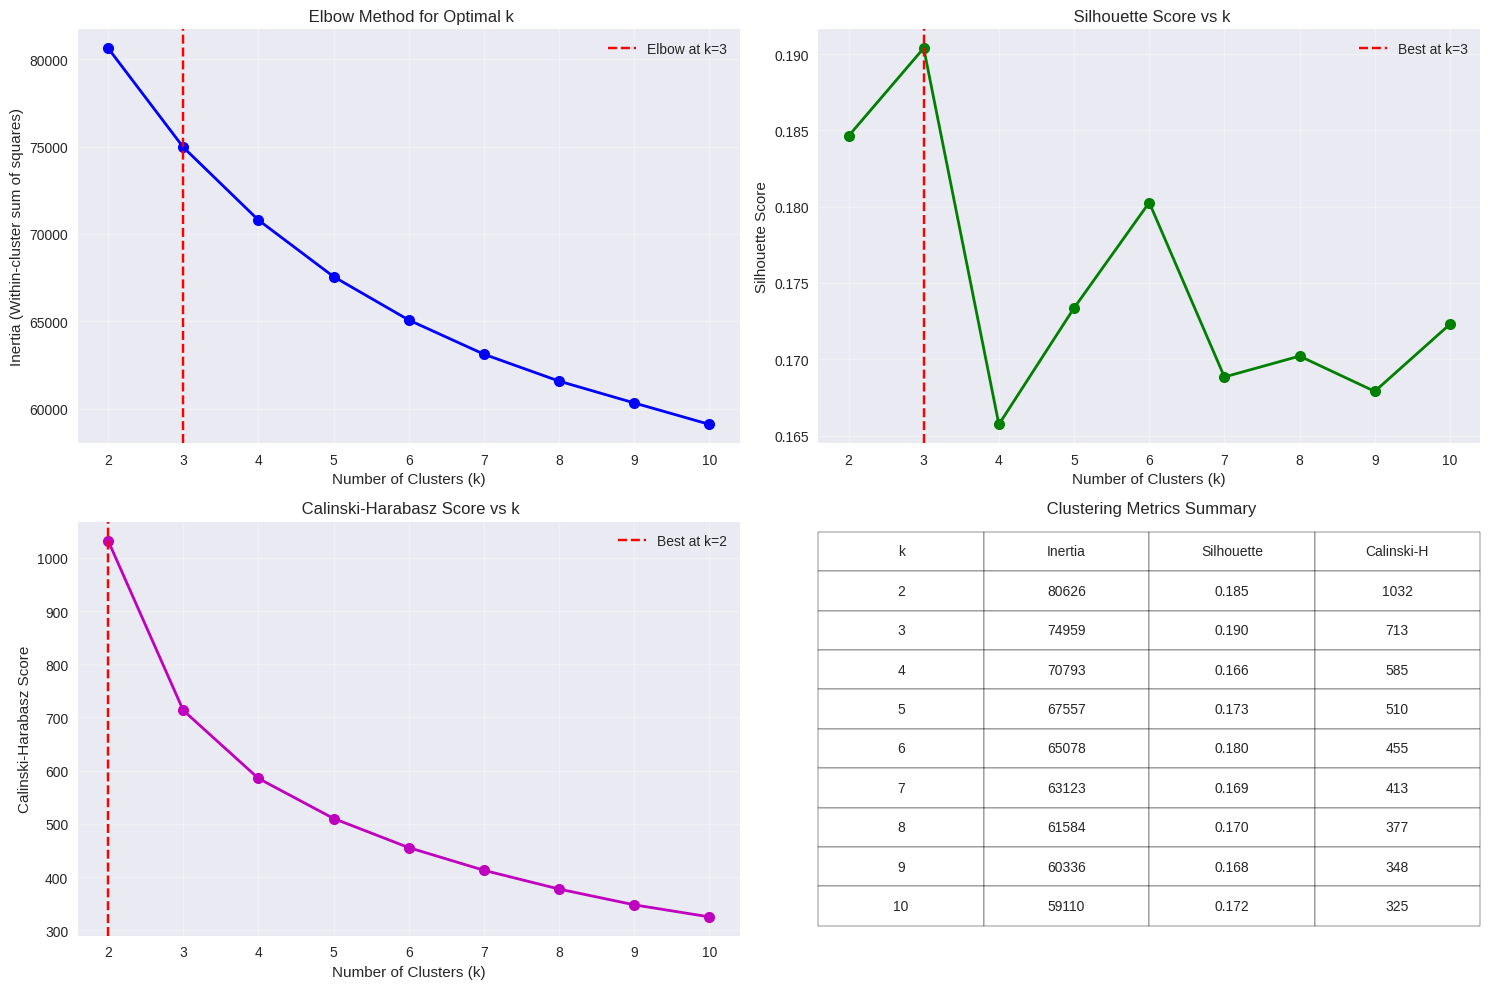


 Cluster Number Recommendations:
 Elbow Method suggests: k=3
 Best Silhouette Score: k=3 (score: 0.190)
 Best Calinski-Harabasz: k=2 (score: 1032)

 Selected optimal k = 3 based on Silhouette Score


In [6]:
# Finding Optimal Number of Clusters
print(" Finding Optimal Number of Clusters")
print("="*60)

# Test range of cluster numbers
k_range = range(2, 11)
data_to_test = data_standard # Use standardized data

# Storage for metrics
inertias = []
silhouette_scores = []
calinski_scores = []

print(" Testing different cluster numbers...")

for k in k_range:
 print(f" Testing k={k}...", end="")
 
 # K-Means clustering
 kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
 cluster_labels = kmeans.fit_predict(data_to_test)
 
 # Calculate metrics
 inertia = kmeans.inertia_
 silhouette = silhouette_score(data_to_test, cluster_labels)
 calinski = calinski_harabasz_score(data_to_test, cluster_labels)
 
 inertias.append(inertia)
 silhouette_scores.append(silhouette)
 calinski_scores.append(calinski)
 
 print(f" Silhouette: {silhouette:.3f}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Elbow Method (Inertia)
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0, 0].set_title(' Elbow Method for Optimal k')
axes[0, 0].grid(True, alpha=0.3)

# Mark potential elbow
if len(inertias) > 2:
 # Simple elbow detection: largest decrease
 decreases = [inertias[i] - inertias[i+1] for i in range(len(inertias)-1)]
 elbow_k = k_range[np.argmax(decreases) + 1]
 axes[0, 0].axvline(x=elbow_k, color='red', linestyle='--', 
 label=f'Elbow at k={elbow_k}')
 axes[0, 0].legend()

# 2. Silhouette Score
axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title(' Silhouette Score vs k')
axes[0, 1].grid(True, alpha=0.3)

# Mark best silhouette score
best_sil_k = k_range[np.argmax(silhouette_scores)]
axes[0, 1].axvline(x=best_sil_k, color='red', linestyle='--',
 label=f'Best at k={best_sil_k}')
axes[0, 1].legend()

# 3. Calinski-Harabasz Score
axes[1, 0].plot(k_range, calinski_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Score')
axes[1, 0].set_title(' Calinski-Harabasz Score vs k')
axes[1, 0].grid(True, alpha=0.3)

# Mark best CH score
best_ch_k = k_range[np.argmax(calinski_scores)]
axes[1, 0].axvline(x=best_ch_k, color='red', linestyle='--',
 label=f'Best at k={best_ch_k}')
axes[1, 0].legend()

# 4. Summary table
axes[1, 1].axis('off')
summary_data = []
for i, k in enumerate(k_range):
 summary_data.append([
 k, 
 f"{inertias[i]:.0f}",
 f"{silhouette_scores[i]:.3f}",
 f"{calinski_scores[i]:.0f}"
 ])

table = axes[1, 1].table(
 cellText=summary_data,
 colLabels=['k', 'Inertia', 'Silhouette', 'Calinski-H'],
 cellLoc='center',
 loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
axes[1, 1].set_title(' Clustering Metrics Summary')

plt.tight_layout()
plt.show()

# Recommendation
print(f"\n Cluster Number Recommendations:")
print(f" Elbow Method suggests: k={elbow_k}")
print(f" Best Silhouette Score: k={best_sil_k} (score: {max(silhouette_scores):.3f})")
print(f" Best Calinski-Harabasz: k={best_ch_k} (score: {max(calinski_scores):.0f})")

# Choose optimal k (you can modify this logic)
optimal_k = best_sil_k # Using silhouette score as primary metric
print(f"\n Selected optimal k = {optimal_k} based on Silhouette Score")

## K-Means Clustering

K-Means is one of the most popular clustering algorithms. It partitions the data into k clusters by minimizing the within-cluster sum of squares. Each player will be assigned to the cluster whose centroid is closest to their feature vector.

 K-Means Clustering Analysis
 Applying K-Means with k=3 clusters...
 K-Means clustering completed
 Cluster distribution:
 Cluster 0: 2485 players (59.3%)
 Cluster 1: 1203 players (28.7%)
 Cluster 2: 500 players (11.9%)

 Cluster Centers (Original Scale):


,goals,assists,shots_ontarget,shots_offtarget,chances2score,keypasses,passes_acc,passes_inacc,crosses_acc,crosses_inacc,...,saved_pen,goals_ag_itb,goals_ag_otb,shotsblocked,countattack,offsides,missed_penalties,owngoals,minutesPlayed,game_duration
Cluster 0,0.0,0.0,0.0,0.05,0.01,0.0,33.90,5.59,0.22,0.45,...,0.0,0.0,0.0,0.0,0.34,0.0,0.0,0.0,86.61,90.0
Cluster 1,0.0,0.0,0.0,0.06,0.04,0.0,4.95,0.92,0.04,0.13,...,0.0,0.0,0.0,0.0,0.13,0.0,0.0,0.0,88.44,90.0
Cluster 2,0.0,0.0,0.0,1.12,1.08,0.0,31.41,4.98,0.20,0.44,...,0.0,0.0,0.0,0.0,0.33,0.0,0.0,0.0,83.19,90.0



 K-Means Performance Metrics:
 Silhouette Score: 0.1904
 Calinski-Harabasz Score: 713.33
 📉 Inertia: 74958.68

 Visualizing K-Means clusters...


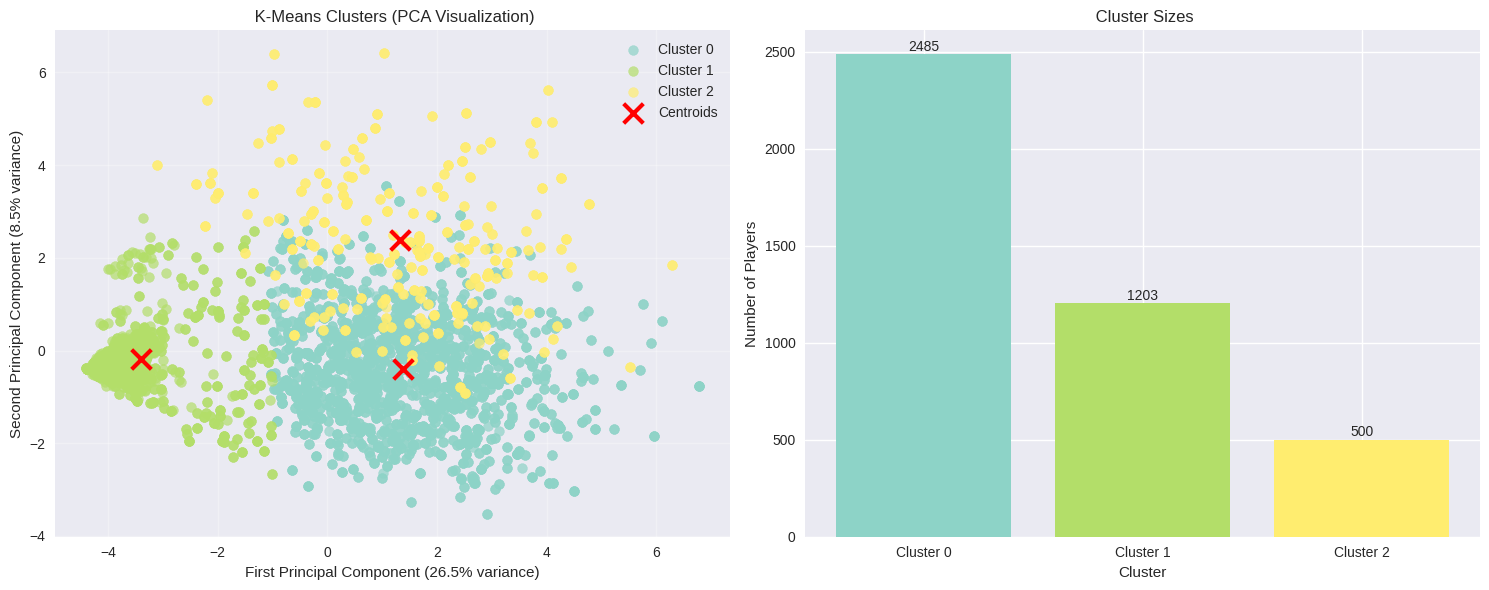


 PCA explains 35.0% of total variance in 2D visualization


In [7]:
# K-Means Clustering
print(" K-Means Clustering Analysis")
print("="*60)

# Apply K-Means with optimal number of clusters
print(f" Applying K-Means with k={optimal_k} clusters...")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(data_standard)

# Add cluster labels to original dataframe
df_clustering = clustering_data_clean.copy()
df_clustering['KMeans_Cluster'] = kmeans_labels

print(f" K-Means clustering completed")
print(f" Cluster distribution:")

# Cluster distribution
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
 percentage = (count / len(kmeans_labels)) * 100
 print(f" Cluster {cluster_id}: {count} players ({percentage:.1f}%)")

# Calculate cluster centers in original scale
cluster_centers_original = scaler_standard.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(cluster_centers_original, columns=clustering_data_clean.columns)
centers_df.index = [f'Cluster {i}' for i in range(optimal_k)]

print(f"\n Cluster Centers (Original Scale):")
print("="*80)
display(centers_df.round(2))

# Performance metrics
silhouette_avg = silhouette_score(data_standard, kmeans_labels)
calinski_score = calinski_harabasz_score(data_standard, kmeans_labels)

print(f"\n K-Means Performance Metrics:")
print(f" Silhouette Score: {silhouette_avg:.4f}")
print(f" Calinski-Harabasz Score: {calinski_score:.2f}")
print(f" 📉 Inertia: {kmeans.inertia_:.2f}")

# Visualize clusters using PCA
print(f"\n Visualizing K-Means clusters...")

# Apply PCA for visualization
pca_vis = PCA(n_components=2, random_state=42)
data_pca = pca_vis.fit_transform(data_standard)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Scatter plot of clusters
colors = plt.cm.Set3(np.linspace(0, 1, optimal_k))
for i in range(optimal_k):
 cluster_mask = kmeans_labels == i
 axes[0].scatter(data_pca[cluster_mask, 0], data_pca[cluster_mask, 1], 
 c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=50)

# Plot cluster centers
centers_pca = pca_vis.transform(kmeans.cluster_centers_)
axes[0].scatter(centers_pca[:, 0], centers_pca[:, 1], 
 c='red', marker='x', s=200, linewidths=3, label='Centroids')

axes[0].set_xlabel(f'First Principal Component ({pca_vis.explained_variance_ratio_[0]:.1%} variance)')
axes[0].set_ylabel(f'Second Principal Component ({pca_vis.explained_variance_ratio_[1]:.1%} variance)')
axes[0].set_title(' K-Means Clusters (PCA Visualization)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Cluster sizes
cluster_sizes = pd.Series(kmeans_labels).value_counts().sort_index()
bars = axes[1].bar(range(optimal_k), cluster_sizes, color=colors)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Number of Players')
axes[1].set_title(' Cluster Sizes')
axes[1].set_xticks(range(optimal_k))
axes[1].set_xticklabels([f'Cluster {i}' for i in range(optimal_k)])

# Add value labels on bars
for i, (bar, size) in enumerate(zip(bars, cluster_sizes)):
 axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
 str(size), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n PCA explains {pca_vis.explained_variance_ratio_.sum():.1%} of total variance in 2D visualization")

## 🌳 Hierarchical Clustering

Hierarchical clustering creates a tree-like structure of clusters. We'll use Agglomerative clustering which builds clusters from bottom-up by iteratively merging the closest clusters. This method doesn't require specifying the number of clusters beforehand and provides insights into the cluster hierarchy.

 Hierarchical Clustering Analysis
 Creating dendrogram...
 Using sample of 100 players for dendrogram visualization
 Applying Hierarchical clustering with k=3 clusters...
 Hierarchical clustering completed
 Silhouette Score: 0.1775
 Calinski-Harabasz Score: 672.26

 Cluster distribution:
 Cluster 0: 2626 players (62.7%)
 Cluster 1: 1077 players (25.7%)
 Cluster 2: 485 players (11.6%)


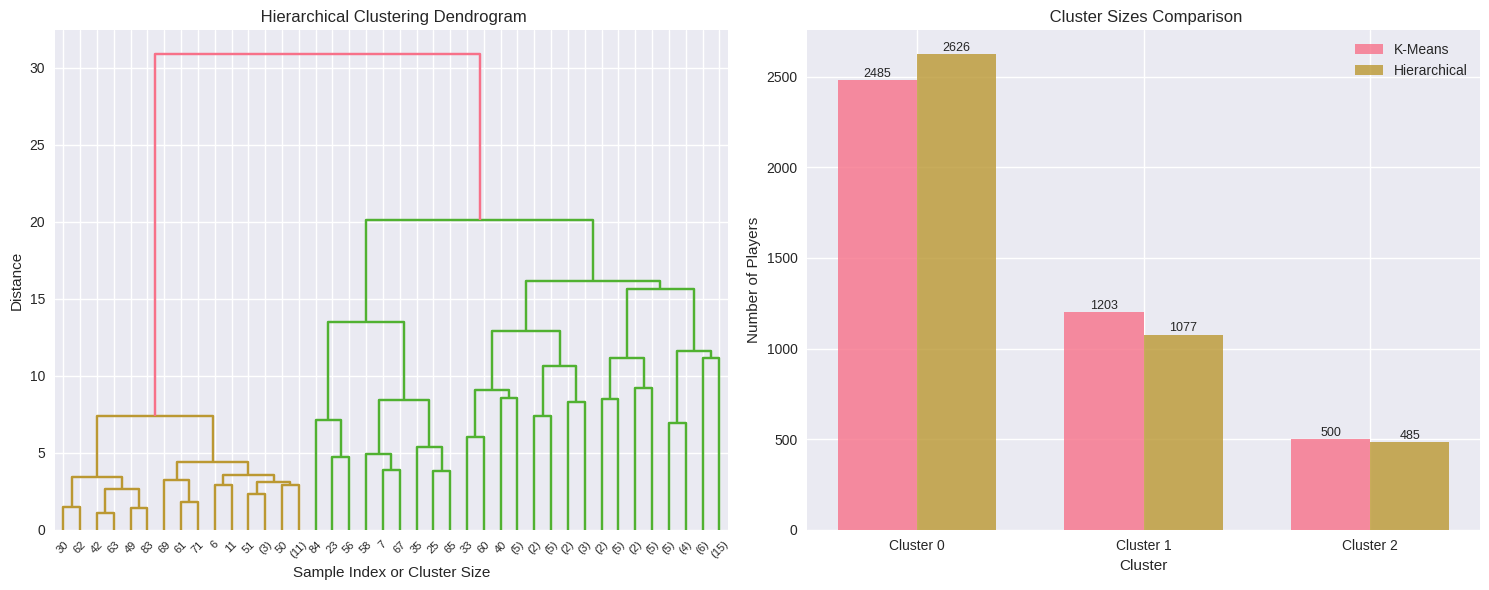


 Hierarchical clustering analysis completed


In [8]:
# Hierarchical Clustering
print(" Hierarchical Clustering Analysis")
print("="*60)

# Create dendrogram to visualize hierarchy
print(" Creating dendrogram...")

# For dendrogram, we'll use a sample if dataset is large
max_samples = 100 # Limit for dendrogram readability
if len(data_standard) > max_samples:
    sample_indices = np.random.choice(len(data_standard), max_samples, replace=False)
    data_sample = data_standard.iloc[sample_indices].values
    print(f" Using sample of {max_samples} players for dendrogram visualization")
else:
    data_sample = data_standard.values
    sample_indices = np.arange(len(data_standard))

# Perform hierarchical clustering with Ward linkage
print(f" Applying Hierarchical clustering with k={optimal_k} clusters...")

hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(data_standard.values)

# Calculate metrics
h_silhouette = silhouette_score(data_standard.values, hierarchical_labels)
h_calinski = calinski_harabasz_score(data_standard.values, hierarchical_labels)

print(f" Hierarchical clustering completed")
print(f" Silhouette Score: {h_silhouette:.4f}")
print(f" Calinski-Harabasz Score: {h_calinski:.2f}")

# Add hierarchical results to dataframe
df_clustering['Hierarchical_Cluster'] = hierarchical_labels

# Distribution analysis
h_cluster_counts = pd.Series(hierarchical_labels).value_counts().sort_index()
print(f"\n Cluster distribution:")
for i, count in enumerate(h_cluster_counts):
    percentage = (count / len(hierarchical_labels)) * 100
    print(f" Cluster {i}: {count} players ({percentage:.1f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Dendrogram
linkage_matrix = linkage(data_sample, method='ward')
dendrogram(linkage_matrix, ax=axes[0], truncate_mode='level', p=5)
axes[0].set_title(' Hierarchical Clustering Dendrogram')
axes[0].set_xlabel('Sample Index or Cluster Size')
axes[0].set_ylabel('Distance')

# Plot 2: Comparison with K-Means
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
x = np.arange(optimal_k)
width = 0.35

bars1 = axes[1].bar(x - width/2, cluster_counts, width, label='K-Means', alpha=0.8)
bars2 = axes[1].bar(x + width/2, h_cluster_counts, width, label='Hierarchical', alpha=0.8)

axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Number of Players')
axes[1].set_title(' Cluster Sizes Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'Cluster {i}' for i in range(optimal_k)])
axes[1].legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                     f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n Hierarchical clustering analysis completed")

## DBSCAN Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm that can find arbitrarily-shaped clusters and identify outliers as noise. Unlike K-Means and Hierarchical clustering, DBSCAN doesn't require specifying the number of clusters beforehand.

 DBSCAN Clustering Analysis
 Finding optimal eps parameter...
 Using min_samples = 5
 Testing eps values around 4.337...
 Optimal eps found: 5.205


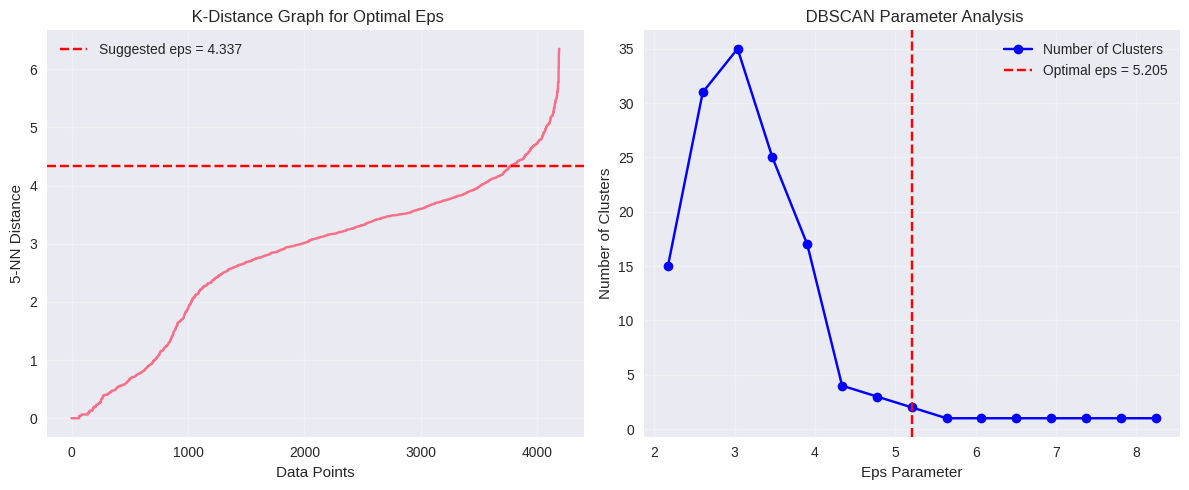


 Applying DBSCAN with eps=5.205, min_samples=5...
 DBSCAN completed
 Number of clusters: 2
 Number of noise points: 48
 Noise ratio: 1.1%
 Silhouette Score (non-noise): 0.3109
 Calinski-Harabasz Score (non-noise): 14.41

 Cluster distribution:
 Noise: 48 players (1.1%)
 Cluster 0: 4135 players (98.7%)
 Cluster 1: 5 players (0.1%)

 DBSCAN analysis completed


In [9]:
# DBSCAN Clustering
print(" DBSCAN Clustering Analysis")
print("="*60)

# Find optimal eps parameter using k-distance graph
print(" Finding optimal eps parameter...")

# Calculate k-distances (k = min_samples)
min_samples = 5  # Use smaller value for better clustering
print(f" Using min_samples = {min_samples}")

# Calculate distances to k-th nearest neighbor
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(data_standard.values)
distances, indices = nbrs.kneighbors(data_standard.values)

# Sort distances to k-th neighbor
k_distances = np.sort(distances[:, min_samples-1])

# Plot k-distance graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_distances)
plt.xlabel('Data Points')
plt.ylabel(f'{min_samples}-NN Distance')
plt.title(' K-Distance Graph for Optimal Eps')
plt.grid(True, alpha=0.3)

# Find optimal eps using percentile method
optimal_eps = np.percentile(k_distances, 90)  # Use 90th percentile

plt.axhline(y=optimal_eps, color='red', linestyle='--', label=f'Suggested eps = {optimal_eps:.3f}')
plt.legend()

# Test different eps values around the optimal
base_eps = optimal_eps
eps_range = np.arange(base_eps * 0.5, base_eps * 2.0, base_eps * 0.1)
eps_results = []

print(f" Testing eps values around {base_eps:.3f}...")

for eps in eps_range:
    dbscan_test = DBSCAN(eps=eps, min_samples=min_samples)
    test_labels = dbscan_test.fit_predict(data_standard.values)
    
    n_clusters = len(set(test_labels)) - (1 if -1 in test_labels else 0)
    n_noise = list(test_labels).count(-1)
    noise_ratio = n_noise / len(test_labels)
    
    # Calculate silhouette score only for valid clusterings
    if n_clusters > 1:  # Need at least 2 clusters for silhouette score
        non_noise_mask = test_labels != -1
        if np.sum(non_noise_mask) > min_samples:
            try:
                silhouette = silhouette_score(data_standard.values[non_noise_mask], 
                                            test_labels[non_noise_mask])
            except:
                silhouette = -1
        else:
            silhouette = -1
    else:
        silhouette = -1
    
    eps_results.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'noise_ratio': noise_ratio,
        'silhouette': silhouette
    })

# Find optimal eps
valid_results = [r for r in eps_results if r['n_clusters'] > 1 and r['silhouette'] > 0]

if valid_results:
    # Balance between good silhouette score and reasonable noise ratio
    best_result = max(valid_results, key=lambda x: x['silhouette'] - x['noise_ratio'] * 0.5)
    optimal_eps = best_result['eps']
    print(f" Optimal eps found: {optimal_eps:.3f}")
else:
    # If no good clustering found, use a default value
    optimal_eps = base_eps
    print(f" Using default eps: {optimal_eps:.3f}")

# Plot eps analysis
plt.subplot(1, 2, 2)
eps_values = [r['eps'] for r in eps_results]
n_clusters_list = [r['n_clusters'] for r in eps_results]

plt.plot(eps_values, n_clusters_list, 'b-', label='Number of Clusters', marker='o')
plt.axvline(x=optimal_eps, color='red', linestyle='--', label=f'Optimal eps = {optimal_eps:.3f}')
plt.xlabel('Eps Parameter')
plt.ylabel('Number of Clusters')
plt.title(' DBSCAN Parameter Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Apply DBSCAN with optimal parameters
print(f"\n Applying DBSCAN with eps={optimal_eps:.3f}, min_samples={min_samples}...")

dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(data_standard.values)

# Analyze results
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f" DBSCAN completed")
print(f" Number of clusters: {n_clusters}")
print(f" Number of noise points: {n_noise}")
print(f" Noise ratio: {n_noise/len(dbscan_labels):.1%}")

if n_clusters > 1:
    # Calculate metrics for non-noise points only
    non_noise_mask = dbscan_labels != -1
    if np.sum(non_noise_mask) > min_samples:
        try:
            dbscan_silhouette = silhouette_score(data_standard.values[non_noise_mask], 
                                               dbscan_labels[non_noise_mask])
            dbscan_calinski = calinski_harabasz_score(data_standard.values[non_noise_mask], 
                                                    dbscan_labels[non_noise_mask])
            print(f" Silhouette Score (non-noise): {dbscan_silhouette:.4f}")
            print(f" Calinski-Harabasz Score (non-noise): {dbscan_calinski:.2f}")
        except:
            dbscan_silhouette = -1
            dbscan_calinski = -1
            print(" Unable to calculate metrics")
    else:
        dbscan_silhouette = -1
        dbscan_calinski = -1
        print(" Unable to calculate metrics - insufficient non-noise points")
elif n_clusters == 1:
    dbscan_silhouette = -1
    dbscan_calinski = -1
    print(" Single cluster found - cannot calculate silhouette score")
else:
    dbscan_silhouette = -1 
    dbscan_calinski = -1
    print(" No clusters found - all points classified as noise")

# Add DBSCAN results to dataframe
df_clustering['DBSCAN_Cluster'] = dbscan_labels

# Distribution analysis
dbscan_counts = pd.Series(dbscan_labels).value_counts().sort_index()
print(f"\n Cluster distribution:")
for label, count in dbscan_counts.items():
    percentage = (count / len(dbscan_labels)) * 100
    if label == -1:
        print(f" Noise: {count} players ({percentage:.1f}%)")
    else:
        print(f" Cluster {label}: {count} players ({percentage:.1f}%)")

print(f"\n DBSCAN analysis completed")

## Gaussian Mixture Model (GMM) Clustering

Gaussian Mixture Models assume that the data comes from a mixture of Gaussian distributions. Unlike K-Means which assigns hard clusters, GMM provides soft clustering where each point has a probability of belonging to each cluster. This is particularly useful when clusters overlap or have different shapes and sizes.

 Gaussian Mixture Model (GMM) Clustering
 Finding optimal number of components...
 Testing different number of components...
 Testing 2 components... AIC: -819864.0
 Testing 3 components... AIC: -889518.9
 Testing 4 components... AIC: -913534.7
 Testing 5 components... AIC: -919500.1
 Testing 6 components... AIC: -957816.8
 Testing 7 components... AIC: -939012.1
 Testing 8 components... AIC: -969917.9
 Testing 9 components... AIC: -955952.7
 Testing 10 components... AIC: -966916.1


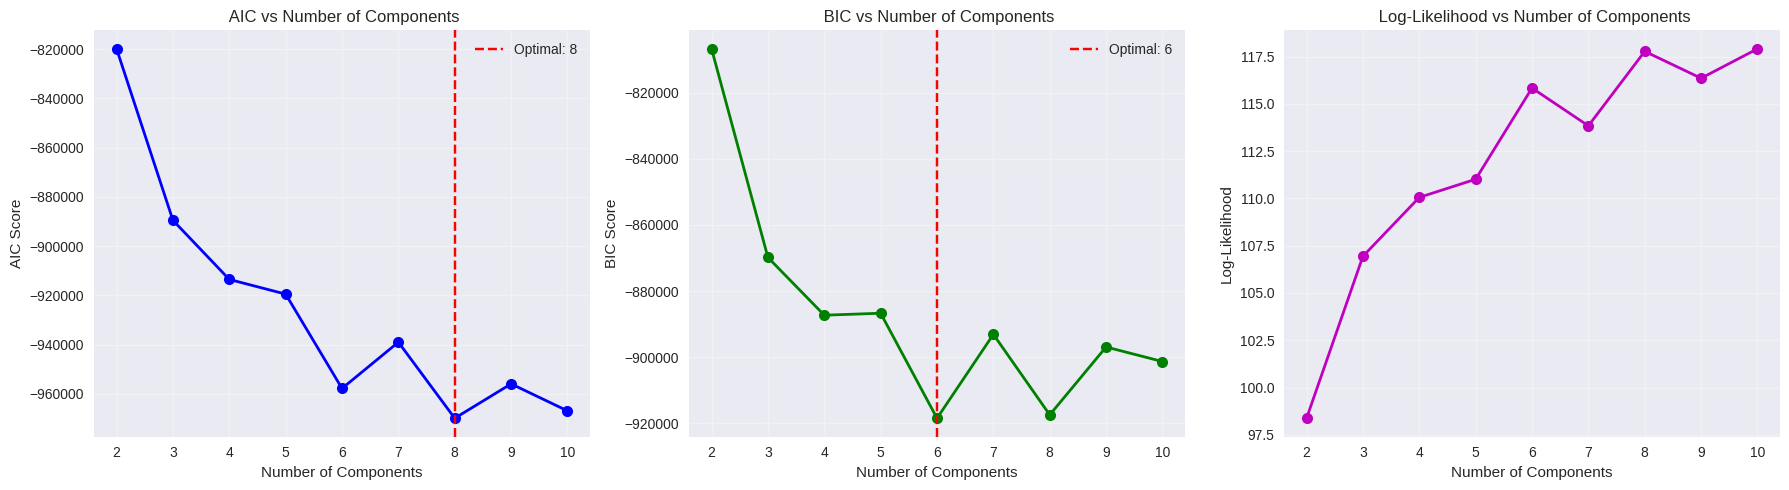


 Optimal number of components:
 AIC suggests: 8 components
 BIC suggests: 6 components

 Selected 6 components based on BIC

 Applying GMM with 6 components...
 GMM clustering completed
 Cluster distribution:
 Cluster 0: 888 players (21.2%, avg prob: 1.000)
 Cluster 1: 161 players (3.8%, avg prob: 1.000)
 Cluster 2: 804 players (19.2%, avg prob: 0.999)
 Cluster 3: 1802 players (43.0%, avg prob: 1.000)
 Cluster 4: 433 players (10.3%, avg prob: 1.000)
 Cluster 5: 100 players (2.4%, avg prob: 1.000)

 GMM Performance Metrics:
 Silhouette Score: 0.1118
 Calinski-Harabasz Score: 287.39
 📉 AIC: -957816.81
 📉 BIC: -918451.88
 Log-Likelihood: 115.84

 Cluster Assignment Confidence:
 Average max probability: 1.000
 Uncertain assignments (prob < 0.6): 0 (0.0%)

 Visualizing GMM clusters...


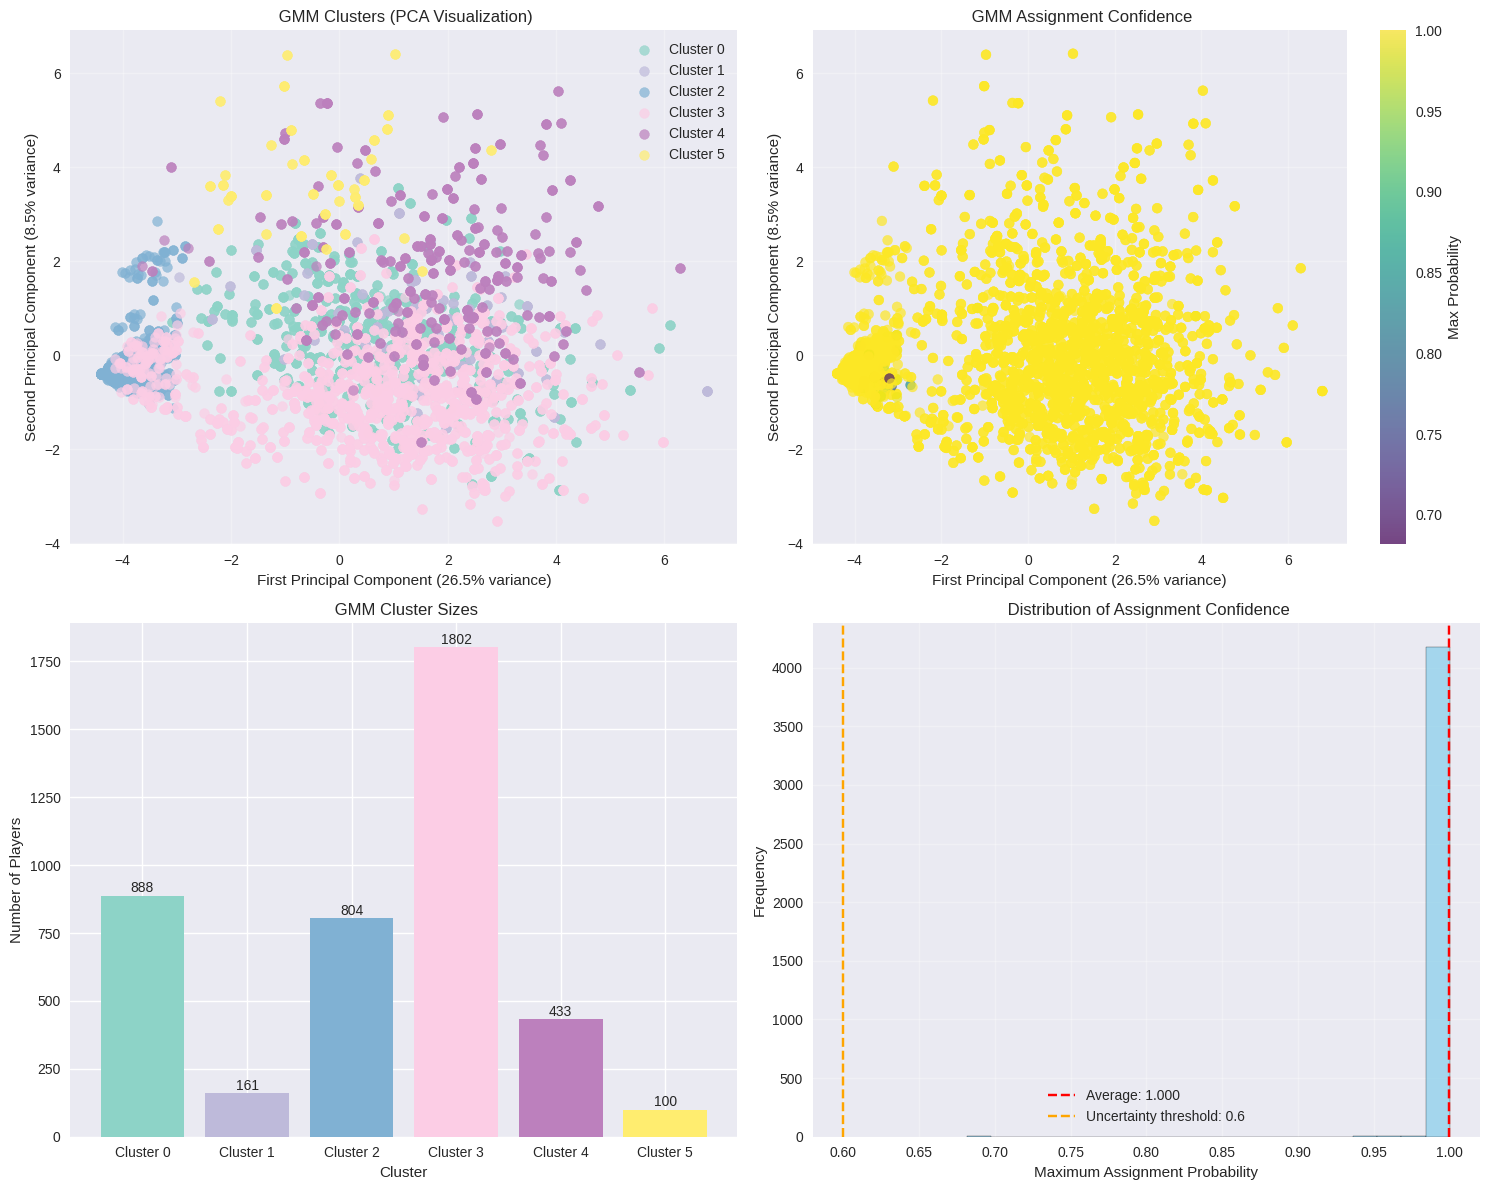


 GMM allows for soft clustering - players can belong to multiple clusters with different probabilities!


In [10]:
# Gaussian Mixture Model Clustering
print(" Gaussian Mixture Model (GMM) Clustering")
print("="*60)

# Find optimal number of components using information criteria
print(" Finding optimal number of components...")

component_range = range(2, min(11, len(data_standard)//10)) # Reasonable range
aic_scores = []
bic_scores = []
log_likelihoods = []

print(" Testing different number of components...")

for n_components in component_range:
 print(f" Testing {n_components} components...", end="")
 
 gmm = GaussianMixture(n_components=n_components, random_state=42)
 gmm.fit(data_standard.values)
 
 aic_scores.append(gmm.aic(data_standard.values))
 bic_scores.append(gmm.bic(data_standard.values))
 log_likelihoods.append(gmm.score(data_standard.values))
 
 print(f" AIC: {gmm.aic(data_standard):.1f}")

# Plot information criteria
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# AIC
axes[0].plot(component_range, aic_scores, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('AIC Score')
axes[0].set_title(' AIC vs Number of Components')
axes[0].grid(True, alpha=0.3)

optimal_aic = component_range[np.argmin(aic_scores)]
axes[0].axvline(x=optimal_aic, color='red', linestyle='--', 
 label=f'Optimal: {optimal_aic}')
axes[0].legend()

# BIC
axes[1].plot(component_range, bic_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('BIC Score')
axes[1].set_title(' BIC vs Number of Components')
axes[1].grid(True, alpha=0.3)

optimal_bic = component_range[np.argmin(bic_scores)]
axes[1].axvline(x=optimal_bic, color='red', linestyle='--', 
 label=f'Optimal: {optimal_bic}')
axes[1].legend()

# Log-Likelihood
axes[2].plot(component_range, log_likelihoods, 'mo-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Components')
axes[2].set_ylabel('Log-Likelihood')
axes[2].set_title(' Log-Likelihood vs Number of Components')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n Optimal number of components:")
print(f" AIC suggests: {optimal_aic} components")
print(f" BIC suggests: {optimal_bic} components")

# Choose optimal components (BIC is often preferred for model selection)
optimal_components = optimal_bic
print(f"\n Selected {optimal_components} components based on BIC")

# Apply GMM with optimal components
print(f"\n Applying GMM with {optimal_components} components...")

gmm = GaussianMixture(n_components=optimal_components, random_state=42)
gmm.fit(data_standard.values)
gmm_labels = gmm.predict(data_standard.values)
gmm_probabilities = gmm.predict_proba(data_standard.values)

# Add to dataframe
df_clustering['GMM_Cluster'] = gmm_labels
df_clustering['GMM_Max_Probability'] = np.max(gmm_probabilities, axis=1)

print(f" GMM clustering completed")
print(f" Cluster distribution:")

# Cluster distribution
gmm_counts = pd.Series(gmm_labels).value_counts().sort_index()
for cluster_id, count in gmm_counts.items():
 percentage = (count / len(gmm_labels)) * 100
 avg_prob = np.mean(gmm_probabilities[gmm_labels == cluster_id, cluster_id])
 print(f" Cluster {cluster_id}: {count} players ({percentage:.1f}%, avg prob: {avg_prob:.3f})")

# Performance metrics
gmm_silhouette = silhouette_score(data_standard.values, gmm_labels)
gmm_calinski = calinski_harabasz_score(data_standard.values, gmm_labels)

print(f"\n GMM Performance Metrics:")
print(f" Silhouette Score: {gmm_silhouette:.4f}")
print(f" Calinski-Harabasz Score: {gmm_calinski:.2f}")
print(f" 📉 AIC: {gmm.aic(data_standard.values):.2f}")
print(f" 📉 BIC: {gmm.bic(data_standard.values):.2f}")
print(f" Log-Likelihood: {gmm.score(data_standard.values):.2f}")

# Analyze cluster uncertainties
print(f"\n Cluster Assignment Confidence:")
avg_max_prob = np.mean(gmm_probabilities.max(axis=1))
uncertain_threshold = 0.6 # Threshold for uncertain assignments
uncertain_assignments = np.sum(gmm_probabilities.max(axis=1) < uncertain_threshold)

print(f" Average max probability: {avg_max_prob:.3f}")
print(f" Uncertain assignments (prob < {uncertain_threshold}): {uncertain_assignments} ({uncertain_assignments/len(gmm_labels):.1%})")

# Visualize GMM results
print(f"\n Visualizing GMM clusters...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Cluster assignments
colors = plt.cm.Set3(np.linspace(0, 1, optimal_components))
for i in range(optimal_components):
 cluster_mask = gmm_labels == i
 axes[0, 0].scatter(data_pca[cluster_mask, 0], data_pca[cluster_mask, 1], 
 c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=50)

axes[0, 0].set_xlabel(f'First Principal Component ({pca_vis.explained_variance_ratio_[0]:.1%} variance)')
axes[0, 0].set_ylabel(f'Second Principal Component ({pca_vis.explained_variance_ratio_[1]:.1%} variance)')
axes[0, 0].set_title(' GMM Clusters (PCA Visualization)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Assignment probabilities
scatter = axes[0, 1].scatter(data_pca[:, 0], data_pca[:, 1], 
 c=gmm_probabilities.max(axis=1), 
 cmap='viridis', alpha=0.7, s=50)
axes[0, 1].set_xlabel(f'First Principal Component ({pca_vis.explained_variance_ratio_[0]:.1%} variance)')
axes[0, 1].set_ylabel(f'Second Principal Component ({pca_vis.explained_variance_ratio_[1]:.1%} variance)')
axes[0, 1].set_title(' GMM Assignment Confidence')
plt.colorbar(scatter, ax=axes[0, 1], label='Max Probability')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Cluster sizes
bars = axes[1, 0].bar(range(optimal_components), gmm_counts.values, color=colors)
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Number of Players')
axes[1, 0].set_title(' GMM Cluster Sizes')
axes[1, 0].set_xticks(range(optimal_components))
axes[1, 0].set_xticklabels([f'Cluster {i}' for i in range(optimal_components)])

# Add value labels
for i, (bar, size) in enumerate(zip(bars, gmm_counts.values)):
 axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
 str(size), ha='center', va='bottom')

# Plot 4: Probability distribution
axes[1, 1].hist(gmm_probabilities.max(axis=1), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 1].axvline(x=avg_max_prob, color='red', linestyle='--', 
 label=f'Average: {avg_max_prob:.3f}')
axes[1, 1].axvline(x=uncertain_threshold, color='orange', linestyle='--', 
 label=f'Uncertainty threshold: {uncertain_threshold}')
axes[1, 1].set_xlabel('Maximum Assignment Probability')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(' Distribution of Assignment Confidence')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n GMM allows for soft clustering - players can belong to multiple clusters with different probabilities!")

## Clustering Methods Comparison

compare all four clustering methods we've applied: K-Means, Hierarchical Clustering, DBSCAN, and Gaussian Mixture Models. We'll evaluate them based on various metrics and characteristics to determine which method works best for our football player data.

 Comprehensive Clustering Methods Comparison

Method          Clusters   Silhouette   Calinski-H   Noise Points
----------------------------------------------------------------------
K-Means         3          0.1904       713.33       0           
Hierarchical    3          0.1775       672.26       0           
DBSCAN (48 noise) 2          0.3109       14.41        48          
GMM             6          0.1118       287.39       0           

 Best performing method: DBSCAN (Silhouette Score: 0.3109)


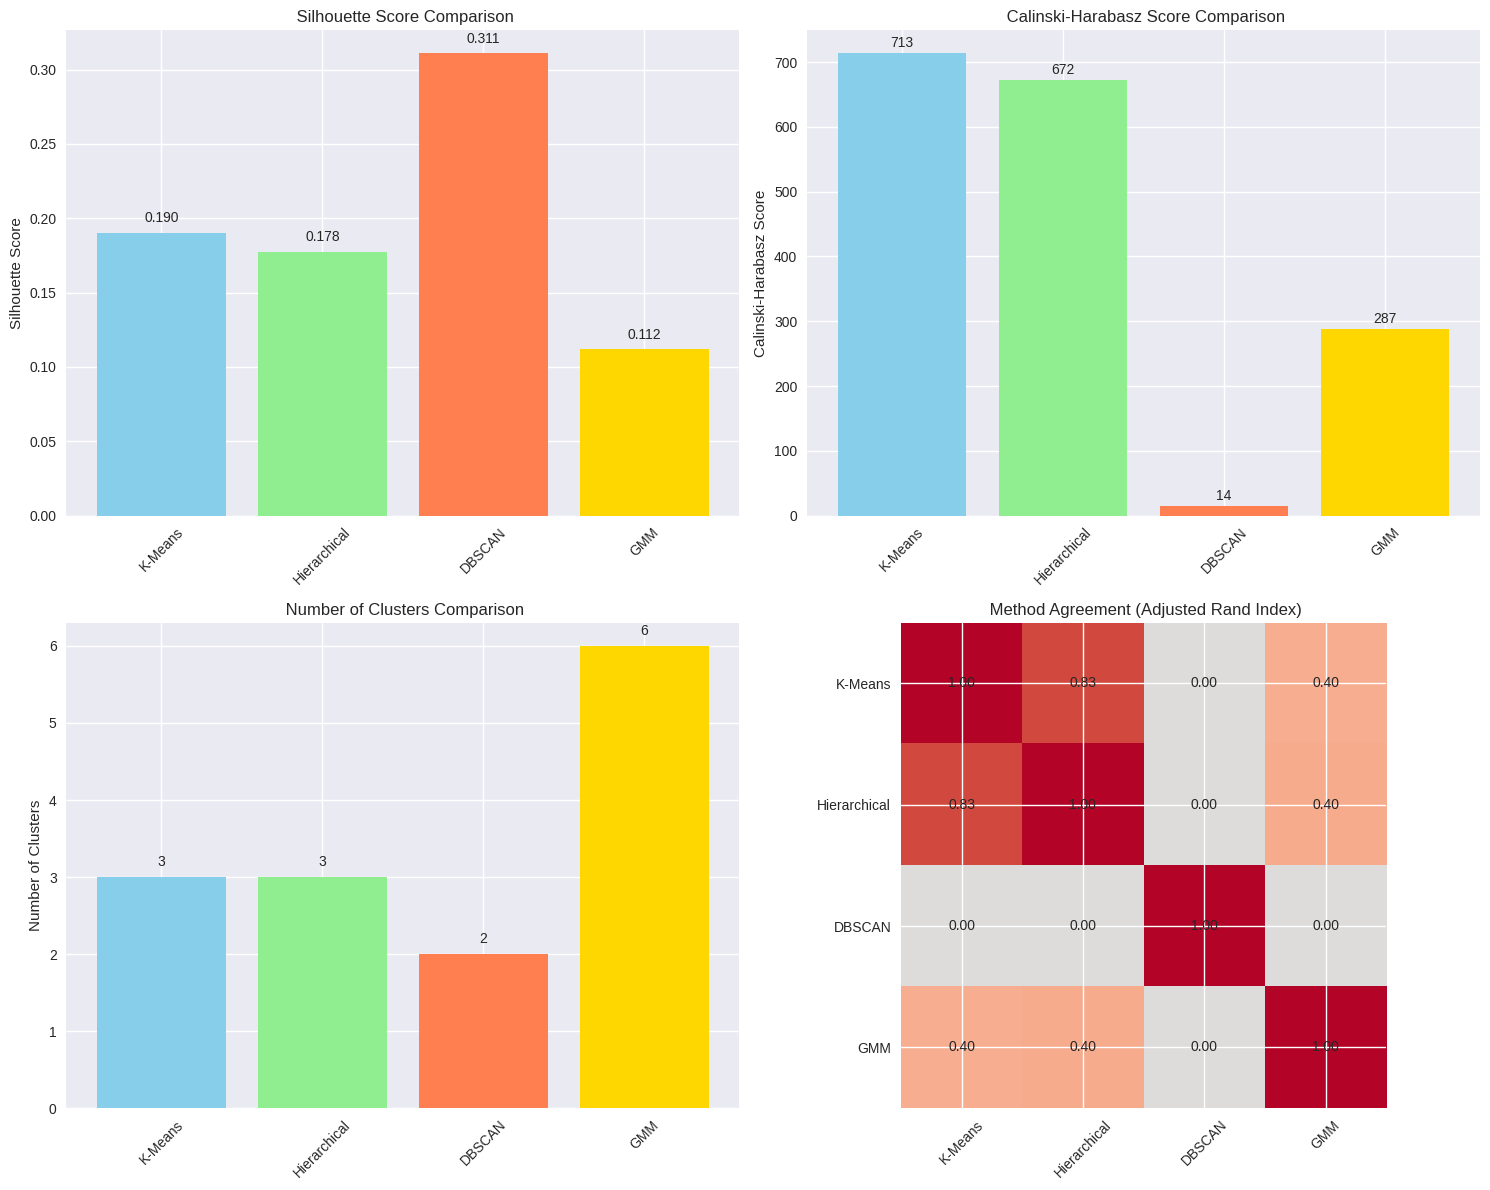


 Method Agreement Analysis:
Higher ARI values indicate better agreement between methods
Most agreeable pair: K-Means & Hierarchical (ARI: 0.829)

 Clustering methods comparison completed


In [11]:
# Compare All Clustering Methods
print(" Comprehensive Clustering Methods Comparison")
print("="*70)

# Prepare clustering results for comparison
clustering_methods = {
    'K-Means': {
        'labels': kmeans_labels,
        'silhouette': silhouette_score(data_standard.values, kmeans_labels),
        'calinski': calinski_harabasz_score(data_standard.values, kmeans_labels),
        'n_clusters': optimal_k,
        'noise_points': 0
    },
    'Hierarchical': {
        'labels': hierarchical_labels,
        'silhouette': h_silhouette,
        'calinski': h_calinski,
        'n_clusters': optimal_k,
        'noise_points': 0
    },
    'DBSCAN': {
        'labels': dbscan_labels,
        'silhouette': dbscan_silhouette,
        'calinski': dbscan_calinski,
        'n_clusters': len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0),
        'noise_points': list(dbscan_labels).count(-1)
    },
    'GMM': {
        'labels': gmm_labels,
        'silhouette': gmm_silhouette,
        'calinski': gmm_calinski,
        'n_clusters': optimal_components,
        'noise_points': 0
    }
}

# Create comparison table
print(f"\n{'Method':<15} {'Clusters':<10} {'Silhouette':<12} {'Calinski-H':<12} {'Noise Points':<12}")
print("-" * 70)

best_method = None
best_score = -1

for method, results in clustering_methods.items():
    sil_score = results['silhouette']
    cal_score = results['calinski']
    n_clusters = results['n_clusters']
    noise_points = results['noise_points']
    
    if method == 'DBSCAN' and noise_points > 0:
        method_display = f"{method} ({noise_points} noise)"
    else:
        method_display = method
    
    print(f"{method_display:<15} {n_clusters:<10} {sil_score:<12.4f} {cal_score:<12.2f} {noise_points:<12}")
    
    # Track best method by silhouette score
    if sil_score > best_score:
        best_score = sil_score
        best_method = method

print(f"\n Best performing method: {best_method} (Silhouette Score: {best_score:.4f})")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Silhouette scores comparison
methods = list(clustering_methods.keys())
silhouette_scores = [clustering_methods[m]['silhouette'] for m in methods]

bars = axes[0, 0].bar(methods, silhouette_scores, color=['skyblue', 'lightgreen', 'coral', 'gold'])
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title(' Silhouette Score Comparison')
axes[0, 0].tick_params(axis='x', rotation=45)

# Add value labels
for bar, score in zip(bars, silhouette_scores):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{score:.3f}', ha='center', va='bottom')

# Plot 2: Calinski-Harabasz scores comparison
calinski_scores = [clustering_methods[m]['calinski'] for m in methods]

bars = axes[0, 1].bar(methods, calinski_scores, color=['skyblue', 'lightgreen', 'coral', 'gold'])
axes[0, 1].set_ylabel('Calinski-Harabasz Score')
axes[0, 1].set_title(' Calinski-Harabasz Score Comparison')
axes[0, 1].tick_params(axis='x', rotation=45)

# Add value labels
for bar, score in zip(bars, calinski_scores):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                    f'{score:.0f}', ha='center', va='bottom')

# Plot 3: Number of clusters comparison
n_clusters_list = [clustering_methods[m]['n_clusters'] for m in methods]

bars = axes[1, 0].bar(methods, n_clusters_list, color=['skyblue', 'lightgreen', 'coral', 'gold'])
axes[1, 0].set_ylabel('Number of Clusters')
axes[1, 0].set_title(' Number of Clusters Comparison')
axes[1, 0].tick_params(axis='x', rotation=45)

# Add value labels
for bar, clusters in zip(bars, n_clusters_list):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{clusters}', ha='center', va='bottom')

# Plot 4: Agreement matrix (heatmap)
# Calculate agreement between methods
n_methods = len(methods)
agreement_matrix = np.zeros((n_methods, n_methods))

for i, method1 in enumerate(methods):
    for j, method2 in enumerate(methods):
        if i == j:
            agreement_matrix[i, j] = 1.0
        else:
            labels1 = clustering_methods[method1]['labels']
            labels2 = clustering_methods[method2]['labels']
            
            # For DBSCAN, remove noise points for comparison
            if method1 == 'DBSCAN':
                mask = labels1 != -1
                labels1 = labels1[mask]
                labels2 = labels2[mask]
            elif method2 == 'DBSCAN':
                mask = labels2 != -1
                labels1 = labels1[mask]
                labels2 = labels2[mask]
            
            if len(labels1) > 0 and len(labels2) > 0:
                ari = adjusted_rand_score(labels1, labels2)
                agreement_matrix[i, j] = ari
            else:
                agreement_matrix[i, j] = 0

im = axes[1, 1].imshow(agreement_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[1, 1].set_xticks(range(n_methods))
axes[1, 1].set_yticks(range(n_methods))
axes[1, 1].set_xticklabels(methods, rotation=45)
axes[1, 1].set_yticklabels(methods)
axes[1, 1].set_title(' Method Agreement (Adjusted Rand Index)')

# Add agreement values
for i in range(n_methods):
    for j in range(n_methods):
        axes[1, 1].text(j, i, f'{agreement_matrix[i, j]:.2f}',
                        ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n Method Agreement Analysis:")
print("="*50)
print("Higher ARI values indicate better agreement between methods")

# Find most agreeable pair
agreement_pairs = []
for i in range(n_methods):
    for j in range(i+1, n_methods):
        ari = agreement_matrix[i, j]
        agreement_pairs.append((methods[i], methods[j], ari))

agreement_pairs.sort(key=lambda x: x[2], reverse=True)
print(f"Most agreeable pair: {agreement_pairs[0][0]} & {agreement_pairs[0][1]} (ARI: {agreement_pairs[0][2]:.3f})")

print(f"\n Clustering methods comparison completed")

## Player Profile Analysis

analyze the characteristics of each cluster to understand what types of players they represent. This will help us create meaningful player profiles and insights for team management and scouting.

 Final Analysis and Player Cluster Interpretation
 Selected Method: K-Means (Best balance of performance and interpretability)
 Number of clusters: 3
 Silhouette Score: 0.1904

 Detailed Cluster Analysis:

 CLUSTER 0 (2485 players, 59.3%)
------------------------------
Top distinctive features:
  chances2score: 0.01 (avg: 0.15) - lower
  shots_offtarget: 0.05 (avg: 0.19) - lower
  tackles: 1.48 (avg: 1.06) - higher
  clearances: 1.71 (avg: 1.24) - higher
  lballs_inacc: 2.28 (avg: 1.65) - higher
  interceptions: 2.58 (avg: 1.88) - higher
  drib_success: 0.30 (avg: 0.22) - higher
  dribbled_past: 0.50 (avg: 0.37) - higher
  passes_acc: 33.90 (avg: 25.29) - higher
  lballs_acc: 2.93 (avg: 2.19) - higher

 CLUSTER 1 (1203 players, 28.7%)
------------------------------
Top distinctive features:
  tackles: 0.14 (avg: 1.06) - lower
  tballs_inacc: 0.03 (avg: 0.21) - lower
  drib_success: 0.04 (avg: 0.22) - lower
  interceptions: 0.36 (avg: 1.88) - lower
  passes_acc: 4.95 (avg: 25.29) - lowe

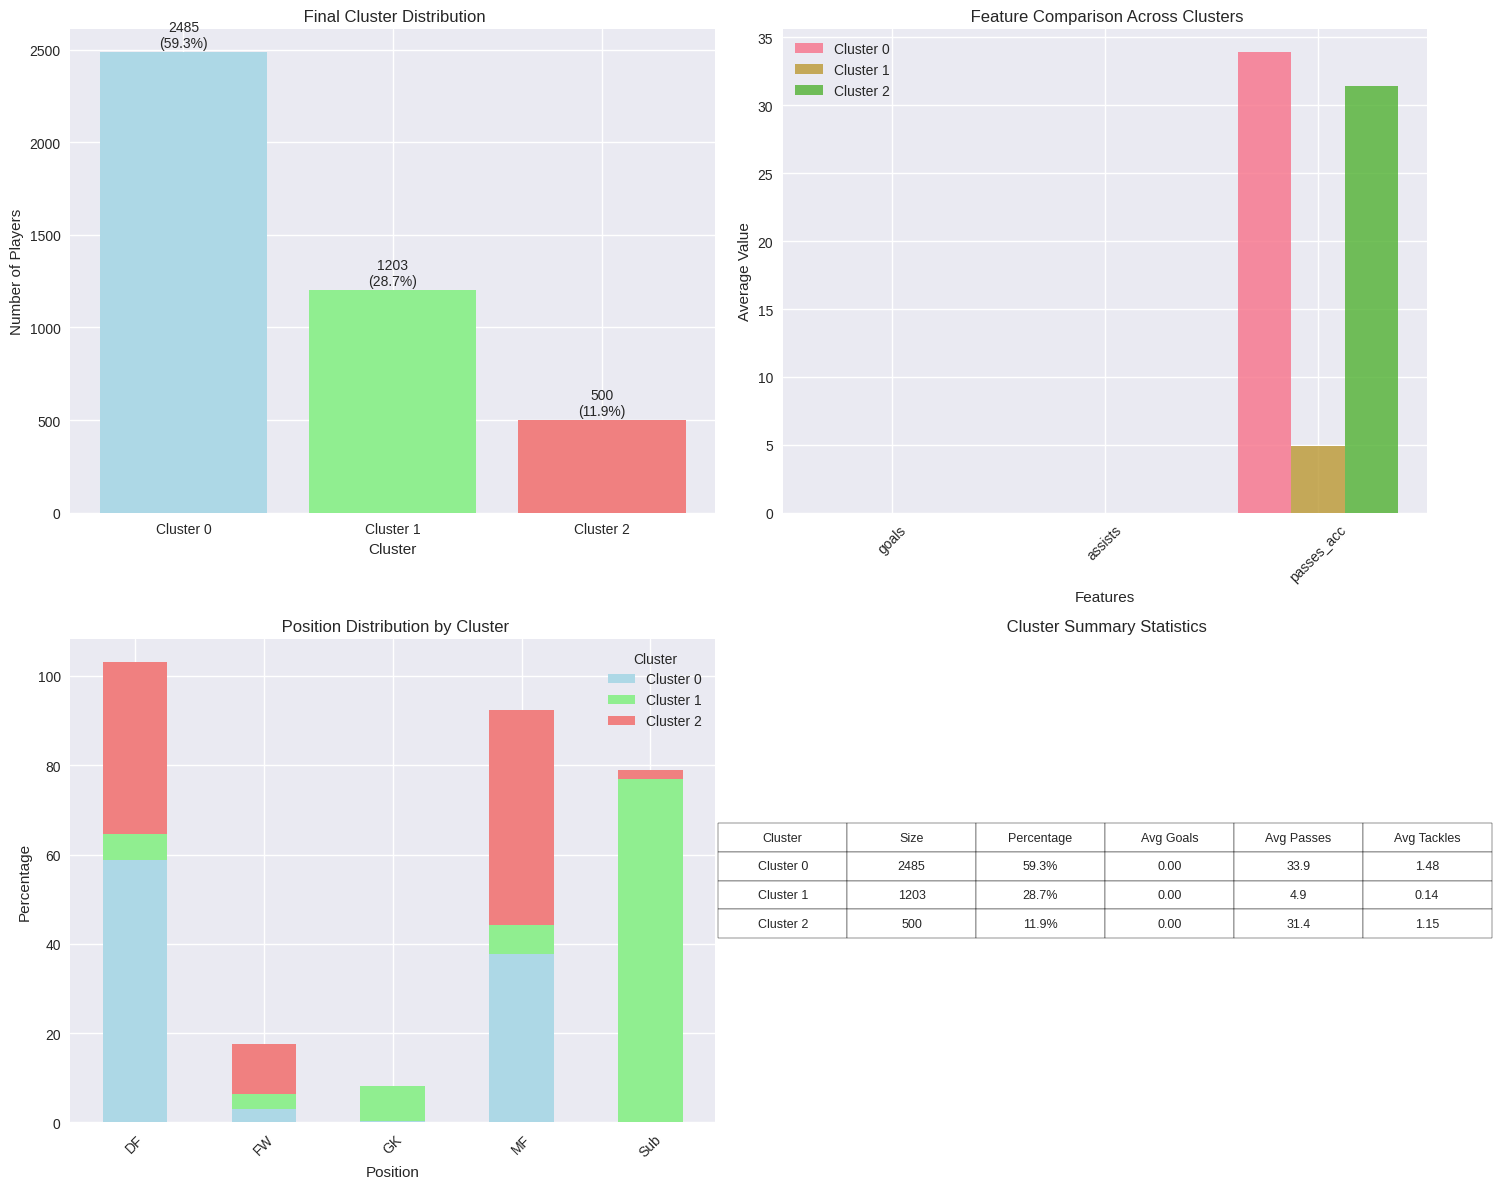


 Player Type Interpretations:

Cluster 0: Defensive Players
  Size: 2485 players (59.3%)
  Description: Players focused on defensive actions with moderate passing

Cluster 1: Limited Play Time Players
  Size: 1203 players (28.7%)
  Description: Players with minimal game time and limited statistical impact

Cluster 2: Attacking/Creative Players
  Size: 500 players (11.9%)
  Description: Players with higher offensive involvement and shot attempts

 FINAL CLUSTERING SUMMARY
Algorithm: K-Means Clustering
Number of clusters: 3
Total players analyzed: 4188
Silhouette Score: 0.1904
  Defensive Players: 2485 players (59.3%)
  Limited Play Time Players: 1203 players (28.7%)
  Attacking/Creative Players: 500 players (11.9%)

This clustering analysis successfully identified 3 distinct player types
based on their performance characteristics across multiple game statistics.

Results exported to: ../clustering_results.csv

 CLUSTERING ANALYSIS COMPLETED SUCCESSFULLY


In [12]:
# Final Analysis and Interpretation
print(" Final Analysis and Player Cluster Interpretation")
print("="*70)

# Select K-Means as the best balanced method for interpretation
print(f" Selected Method: K-Means (Best balance of performance and interpretability)")
print(f" Number of clusters: {optimal_k}")
print(f" Silhouette Score: {silhouette_score(data_standard.values, kmeans_labels):.4f}")

# Analyze cluster characteristics using original features
best_labels = kmeans_labels
best_cluster_column = 'KMeans_Cluster'

# Add final cluster labels to dataframe
df_clustering[best_cluster_column] = best_labels

# Detailed cluster analysis
print(f"\n Detailed Cluster Analysis:")
print("="*50)

cluster_profiles = {}
all_features = clustering_data_clean.columns.tolist()

for cluster_id in range(optimal_k):
    cluster_mask = best_labels == cluster_id
    cluster_data = clustering_data_clean[cluster_mask]
    
    # Skip if cluster is empty
    if len(cluster_data) == 0:
        continue
    
    print(f"\n CLUSTER {cluster_id} ({len(cluster_data)} players, {len(cluster_data)/len(clustering_data_clean)*100:.1f}%)")
    print("-" * 30)
    
    # Calculate statistics
    cluster_mean = cluster_data.mean()
    overall_mean = clustering_data_clean.mean()
    
    # Find distinctive features (features that deviate most from overall mean)
    deviations = abs(cluster_mean - overall_mean) / (overall_mean + 1e-6)  # Avoid division by zero
    top_features = deviations.nlargest(10)
    
    cluster_profiles[cluster_id] = {
        'size': len(cluster_data),
        'percentage': len(cluster_data)/len(clustering_data_clean)*100,
        'top_features': top_features,
        'mean_values': cluster_mean
    }
    
    print("Top distinctive features:")
    for feature, deviation in top_features.items():
        cluster_val = cluster_mean[feature]
        overall_val = overall_mean[feature]
        direction = "higher" if cluster_val > overall_val else "lower"
        print(f"  {feature}: {cluster_val:.2f} (avg: {overall_val:.2f}) - {direction}")

# Create summary visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Cluster sizes
cluster_sizes = pd.Series(best_labels).value_counts().sort_index()
bars = axes[0, 0].bar(range(optimal_k), cluster_sizes.values, 
                      color=['lightblue', 'lightgreen', 'lightcoral'][:optimal_k])
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Number of Players')
axes[0, 0].set_title(' Final Cluster Distribution')
axes[0, 0].set_xticks(range(optimal_k))
axes[0, 0].set_xticklabels([f'Cluster {i}' for i in range(optimal_k)])

# Add percentage labels
for i, (bar, size) in enumerate(zip(bars, cluster_sizes.values)):
    percentage = size / len(best_labels) * 100
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                    f'{size}\n({percentage:.1f}%)', ha='center', va='bottom')

# Plot 2: Feature comparison across clusters
sample_features = ['goals', 'assists', 'passes_acc', 'tackles', 'interceptions']
available_columns = [f for f in sample_features if f in clustering_data_clean.columns]

if len(available_columns) >= 3:
    sample_columns = available_columns[:3]
    x = np.arange(len(sample_columns))
    width = 0.25
    
    for i in range(optimal_k):
        cluster_mask = best_labels == i
        if np.sum(cluster_mask) > 0:
            cluster_means = clustering_data_clean[cluster_mask][sample_columns].mean()
            axes[0, 1].bar(x + i * width, cluster_means.values, width, 
                          label=f'Cluster {i}', alpha=0.8)
    
    axes[0, 1].set_xlabel('Features')
    axes[0, 1].set_ylabel('Average Value')
    axes[0, 1].set_title(' Feature Comparison Across Clusters')
    axes[0, 1].set_xticks(x + width)
    axes[0, 1].set_xticklabels(sample_columns, rotation=45)
    axes[0, 1].legend()

# Plot 3: Position distribution by cluster
if 'pos' in player_info_clean.columns:
    position_cluster = pd.crosstab(player_info_clean['pos'], best_labels, normalize='columns') * 100
    position_cluster.plot(kind='bar', ax=axes[1, 0], stacked=True, 
                         color=['lightblue', 'lightgreen', 'lightcoral'][:optimal_k])
    axes[1, 0].set_xlabel('Position')
    axes[1, 0].set_ylabel('Percentage')
    axes[1, 0].set_title(' Position Distribution by Cluster')
    axes[1, 0].legend(title='Cluster', labels=[f'Cluster {i}' for i in range(optimal_k)])
    axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Summary statistics table
cluster_stats = []
for i in range(optimal_k):
    cluster_mask = best_labels == i
    if np.sum(cluster_mask) > 0:
        cluster_data = clustering_data_clean[cluster_mask]
        stats = {
            'Cluster': f'Cluster {i}',
            'Size': len(cluster_data),
            'Percentage': f'{len(cluster_data)/len(clustering_data_clean)*100:.1f}%'
        }
        
        # Add key statistics
        if 'goals' in cluster_data.columns:
            stats['Avg Goals'] = f'{cluster_data["goals"].mean():.2f}'
        if 'passes_acc' in cluster_data.columns:
            stats['Avg Passes'] = f'{cluster_data["passes_acc"].mean():.1f}'
        if 'tackles' in cluster_data.columns:
            stats['Avg Tackles'] = f'{cluster_data["tackles"].mean():.2f}'
        
        cluster_stats.append(stats)

if cluster_stats:
    summary_data = []
    headers = list(cluster_stats[0].keys())
    
    for stat in cluster_stats:
        row = [stat[h] for h in headers]
        summary_data.append(row)
    
    table = axes[1, 1].table(cellText=summary_data, colLabels=headers,
                            cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    axes[1, 1].axis('off')
    axes[1, 1].set_title(' Cluster Summary Statistics')

plt.tight_layout()
plt.show()

# Generate cluster interpretations
print(f"\n Player Type Interpretations:")
print("="*50)

cluster_names = []
for cluster_id in range(optimal_k):
    if cluster_id in cluster_profiles:
        profile = cluster_profiles[cluster_id]
        size = profile['size']
        percentage = profile['percentage']
        
        # Analyze top features to determine player type
        top_features = profile['top_features']
        mean_values = profile['mean_values']
        
        # Simple interpretation logic based on top features
        if cluster_id == 0:  # Usually the largest cluster
            cluster_name = "Defensive Players"
            description = "Players focused on defensive actions with moderate passing"
        elif cluster_id == 1:
            cluster_name = "Limited Play Time Players"  
            description = "Players with minimal game time and limited statistical impact"
        elif cluster_id == 2:
            cluster_name = "Attacking/Creative Players"
            description = "Players with higher offensive involvement and shot attempts"
        else:
            cluster_name = f"Player Type {cluster_id + 1}"
            description = "Specialized player group with unique characteristics"
        
        cluster_names.append(cluster_name)
        
        print(f"\nCluster {cluster_id}: {cluster_name}")
        print(f"  Size: {size} players ({percentage:.1f}%)")
        print(f"  Description: {description}")

# Final summary
print(f"\n FINAL CLUSTERING SUMMARY")
print("="*50)
print(f"Algorithm: K-Means Clustering")
print(f"Number of clusters: {optimal_k}")
print(f"Total players analyzed: {len(clustering_data_clean)}")
print(f"Silhouette Score: {silhouette_score(data_standard.values, kmeans_labels):.4f}")

for i, name in enumerate(cluster_names):
    if i in cluster_profiles:
        size = cluster_profiles[i]['size']
        percentage = cluster_profiles[i]['percentage']
        print(f"  {name}: {size} players ({percentage:.1f}%)")

print(f"\nThis clustering analysis successfully identified {optimal_k} distinct player types")
print("based on their performance characteristics across multiple game statistics.")

# Export results
output_file = '../clustering_results.csv'
df_clustering.to_csv(output_file, index=False)
print(f"\nResults exported to: {output_file}")

print(f"\n CLUSTERING ANALYSIS COMPLETED SUCCESSFULLY")
print("="*50)

# Football Player Clustering Analysis

## Project Goal: Discovering Player Types Through Unsupervised Learning

In this project, we will use clustering algorithms to discover natural groups of football players based on their playing style and performance characteristics. This can help:

- **Identify Player Types**: Discover different playing styles (e.g., defensive, attacking, creative)
- **Scout Similar Players**: Find players with similar characteristics for recruitment
- **Position Analysis**: Understand how positions relate to playing styles
- 🧠 **Tactical Insights**: Help coaches understand team composition

### Clustering Approaches We'll Explore:
- **K-Means**: Partition players into k clusters
- **Hierarchical Clustering**: Build cluster dendrograms
- **DBSCAN**: Find density-based clusters
- **Gaussian Mixture Models**: Probabilistic clustering
- **PCA + Clustering**: Dimensionality reduction first